# Днес:

* Ще построим граф за автоматично смятане на градиентите
* Ще разгледаме `Tensorflow`
* Ще разгледаме `Keras`

In [1]:
import math

import numpy as np
import pandas as pd
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

%matplotlib inline
sns.set()

# Graph

Целта на графа е да вкараме всички операции от примера и да имаме автоматично диференциране и ъпдейтване на теглата.

## Елементите на графа трябва да имат следните функционалности:
* `forward` - пресямата операцията.
* `backward` - пресмята и запомня градиентите за текущата операция.
* `update weights` - обновява теглата с помощтта на "the update rule".

## Изпълниние на графа:
* Когато се изпълнява, графа първо ще извика `forward` за всеки от елементите и ще запази стойностотите им.
* След което преизползваме стойностите в `backward pass`, изпълнявайки го върху елементите в обратен ред.
* Накрая чрез  `update_wights` ще извадим пресметнатите градиенти от съответните им тегла.

# Ще направим граф за многослойна NN за регресия.

## За улеснение няма да е точно граф - по-точно няма да има разклонения.
Ще започнем отзад напред и първо ще дефинираме `MSE` - `op4` от примера. 
* Последната операция (cost) - няма да имплементира `update_weights` по очевидни причини. 

# Да погледнем отново какви са стъпките в графа за регресия:


$ \hat y =  g(X W_1 + b) W_2 + b_2$
<br/>
<br/>$ op_1 = X W_1 + b $
<br/>$ op_2 = \sigma( op_1) $
<br/>$ op_3 = op_2 * W_2 + b_2 = \hat y $
<br/>$ op_4 = J(op_3) $, където $J(W) = \frac {1}{2} \big ( \hat y -  y \big ) ^2 $



# Ще започнем имплементацията с `MSE`

In [2]:
class MSE:
    def __init__(self, y):
        self.y = y

    def forward(self, X):
        self.X = X.ravel()
        first_term = 1. / (2. * len(X))
        norm = np.linalg.norm(self.y - X)
        self.value = first_term * np.square(norm)
        return self.value

    def backward(self, _):
        dX = self.X - self.y
        return dX

# Следва `Linear Unit`, който пресмята `wx + b` или `op1` и `op3` от горния пример.

# Да видим пак `backward pass` на графа.

$$\frac {\partial op_4} {\partial W_2  } = \frac {\partial } {\partial W_2  } \frac {1} {2} \big ( op3 - y \big )^2 = $$

$$ = (op3 - y) \frac {\partial } {\partial W_2  } \big ( op3 - y\big ) =$$

$$ = (op3 - y) \frac {\partial } {\partial W_2  } \big ( op_2 * W_2 + b_2 - y\big ) =$$

$$ = (op3 - y) op_2 $$



In [3]:
class Linear:
    def __init__(self, x_dim, h_dim, name=None):
        self.W = np.random.randn(x_dim, h_dim)
        self.b = np.random.randn(h_dim)
        self.name = name
        
    def forward(self, X):
        self.X = X
        self.values = np.dot(X, self.W) + self.b
        return self.values

    def backward(self, dZ):
        self.db = np.dot(np.ones((1, dZ.shape[0]), dtype=np.float64), dZ)
        self.dW = np.dot(np.transpose(self.X), dZ)

        if dZ.ndim == 1:
            dZ = np.expand_dims(dZ, axis=1)

        self.dX =  dZ @ np.transpose(self.W)
        return self.dX

    def update(self, alpha):
        self.W += - alpha * self.dW.reshape(self.W.shape)
        self.b += - alpha * self.db.ravel()

# В `__init__` подаваме `x_dim` и `h_dim`.


* `x_dim` - колко фичъра има в `x`.
* `h_dim` - колко скрити неврона искаме да има в новия слой.

`h_dim` може да бъде `1` за последния слой.

* Когато умножим `X` по `W` ще получим нова матрица. 
* В получената матрица броя на редовете ще остане същия като на `X` (семплите), а броя на колоните ще са новите неврони (фичъри) в скрития слой.

Ред по колона :D

![](imgs/matrix-multiply-a.svg)

# Следва кода за `Sigmoid`

Тук нещата са малко по-тривиални

In [4]:
class Sigmoid:
    def forward(self, X):
        self.values = 1.0 / (1.0 + np.exp(-X))
        return self.values

    def backward(self, dZ):
        return (1.0 - self.values) * self.values * dZ

# Дебъгването е доста трудоемко. 

* Най-честите грешки са с измеренията на тензорите.
* Най-лесно се дебъгва, като се гледат размерите на матриците.

```
print("\n"*4)
print(self.name)
print(f'self.db {self.db}')
print(f'self.X: {self.X}')
print(f'dZ: {dZ}')
print(f'self.dW: {self.dW}')
print(f"self.W, {self.W}")
print("\n"*4)
```

# До тук добре. Имаме функциите.
## Трябва ни нещо което да ги извиква в правилния ред!

In [5]:
from sklearn.base import BaseEstimator

class NeuralNetwork(BaseEstimator):
    def __init__(self, model, alpha=0.01, iterations=100):
        self.alpha = alpha
        self.iterations = iterations
        self.model = model
    
    def fit(self, X, y=None):
        model = self.model
        self.errors = []
        
        for i in range(self.iterations):
            z = X
            for e in self.model:
                z = e.forward(z)
                if isinstance(e, MSE):
                    self.errors.append(e.value)

            dZ = None
            for e in self.model[::-1]:
                dZ = e.backward(dZ)

            for e in self.model:
                if hasattr(e, 'update'):
                    e.update(self.alpha)
                    
        return self
        
    def predict(self, X):
        z = X
        for e in model[:-1]:
            z = e.forward(z)
        return z


# Готово. Да пробваме графа!

Ще генерираме `dummy dataset` с който да екпсериментираме.

In [6]:
X = np.array([
    [1, 2, 3],
    [-1, -2, -3]
])

y = np.array([0, 1])

In [7]:
np.random.seed(1)

model = [
    Linear(3, 5, "Linear 1"),
    Sigmoid(),

    # Linear(5, 4, "Linear 2"),
    # Sigmoid(),
    
    Linear(5, 1, "Linear 3"),
    MSE(y)
]

nn = NeuralNetwork(model)
nn.fit(X)
nn.predict(X)

array([[-0.02867645],
       [ 1.02624718]])

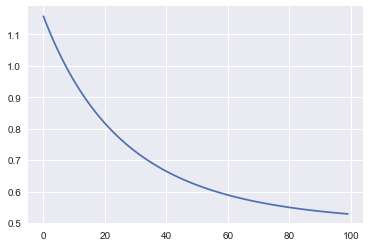

In [8]:
plt.plot(nn.errors);

In [9]:
def plot_different_lr():
    plt.figure(figsize=(12,12))
    for i, lr in enumerate([0.001, 0.01, 0.1, 0.4, 0.5, 0.6]):
        np.random.seed(1)
        model = [Linear(3, 5, "Linear 1"), Sigmoid(), Linear(5, 1, "Linear 3"), MSE(y)]
        nn = NeuralNetwork(model, alpha=lr)
        nn.fit(X)
        plt.subplot(2,3, i+1)
        plt.title(lr)
        plt.plot(nn.errors);

# Как ще изглеждат грешките (`Learning Curves`) с различни стойности на `alpha` (learning rate):

/Users/lachezar/.pyenv/versions/3.6.2/envs/fmi-explore/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


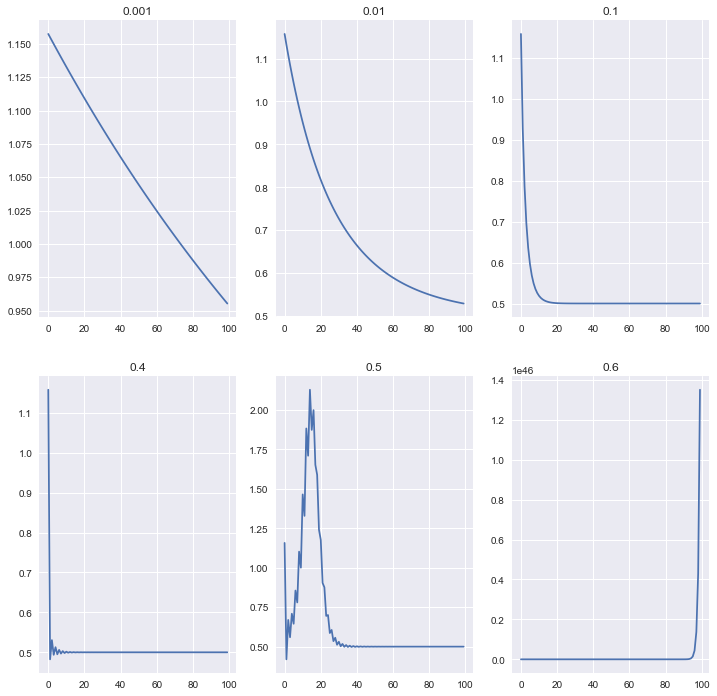

In [10]:
plot_different_lr()

# Да сравним новия ни граф с `LinearRegression` от `sklearn`

За целта ще използваме `boston house price` данните.

In [11]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [12]:
boston = load_boston()
X = boston.data
X = StandardScaler().fit(X).transform(X)
y = boston.target

x_train, x_test, y_train, y_test = train_test_split(X, y)

regressor = LinearRegression().fit(x_train, y_train)
print("train score:", regressor.score(x_train, y_train))
print("test score:", regressor.score(x_test, y_test))


train score: 0.736897285102
test score: 0.742545680576


/Users/lachezar/.pyenv/versions/3.6.2/envs/fmi-explore/lib/python3.6/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


# Ще конструираме невронната мрежа.
Първо трябва да видим какви са размерите на входните фичъри.

In [13]:
x_train.shape

(379, 13)

In [14]:
np.random.seed(1)
model = [
    Linear(13, 100, "Linear 1"),
    Sigmoid(),

    Linear(100, 50, "Linear 2"),
    Sigmoid(),
    
    Linear(50, 1, "Linear 3"),
    MSE(y_train)
]

nn = NeuralNetwork(model, alpha=0.0001, iterations=1000)
nn.fit(x_train);

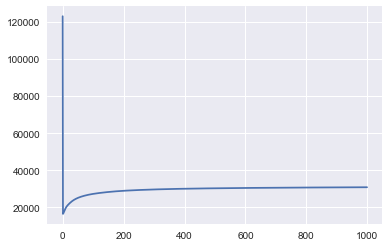

In [15]:
plt.plot(nn.errors);

In [16]:
print(r2_score(y_train, nn.predict(x_train)))
print(r2_score(y_test, nn.predict(x_test)))

0.976173280251
0.832469042921


# Бихме резултата на линейната регресия!
# За домашно имплементирайте:

* `relu`
* `softmax`
* `log loss`, среща се и с името `categorical cross entropy`
* `decaying lr` и `momentum`
* В `Linear` елемент да се подава само едно измерение - това за бр. неврони в скрития слой. Другото ще се смята автоматично в първото изивкване на `forward` от подаденото `x`
* Добавете регуларизации `l1` и `l2`. Всеки `Linear` елемент може да има различни стойности за `l1` и `l2`. 
* Направете класификация

\* Само ако Стефан напише автоматизирани тестове за проверка! 

# Tensorflow

* An open-source software library for Machine Intelligence
* https://www.tensorflow.org/
* `pip install tensorflow==1.3.0` 
* `pip install tensorflow-gpu==1.3.0`


защото с последната версия (1.4.0):
```
RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
```

In [17]:
import tensorflow as tf

# Model parameters
W = tf.Variable([0.3], dtype=tf.float32)
b = tf.Variable([-0.3], dtype=tf.float32)

# Model input and output
x = tf.placeholder(tf.float32)
y = tf.placeholder(tf.float32)

linear_model = W*x + b

In [18]:
# loss
loss = tf.reduce_sum(tf.square(linear_model - y)) # sum of the squares
# optimizer
optimizer = tf.train.GradientDescentOptimizer(0.01)
train = optimizer.minimize(loss)

In [19]:
# training data
x_train = [1, 2, 3, 4]
y_train = [0, -1, -2, -3]

# training loop
init = tf.global_variables_initializer()
sess = tf.Session()

sess.run(init) # initialize W and b with 0.3 and -0.3
for i in range(1000):
    sess.run(train, {x: x_train, y: y_train})

In [20]:
# evaluate training accuracy
curr_W, curr_b, curr_loss = sess.run([W, b, loss], {x: x_train, y: y_train})
print(f"W: {curr_W} b: {curr_b} loss: {curr_loss}")

# y = -1 * x + 1 

W: [-0.9999969] b: [ 0.99999082] loss: 5.699973826267524e-11


![](imgs/dummy_tensor_board.png)

# Малко по-истински пример

In [21]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
print(mnist.train.images.shape)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
(55000, 784)


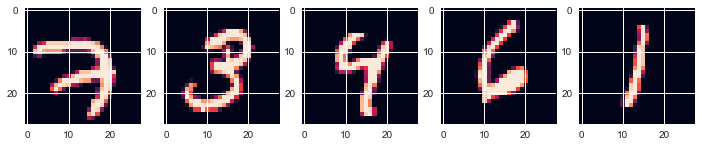

In [22]:
plt.figure(figsize=(12,8))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(mnist.train.images[i].reshape(28, 28))

In [23]:
x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

In [24]:
W = tf.Variable(tf.zeros([784,10]))
b = tf.Variable(tf.zeros([10]))

In [25]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

y = tf.matmul(x,W) + b

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))

In [26]:
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

for _ in range(1000):
    batch = mnist.train.next_batch(100)
    train_step.run(feed_dict={x: batch[0], y_: batch[1]})


In [27]:
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

print(accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels}))

0.9186


# Да направим 2 слойна

In [28]:
W1 = tf.Variable(tf.random_normal([784,200], seed=5))
b1 = tf.Variable(tf.zeros([200]))
h1 = tf.nn.relu(tf.matmul(x, W1) + b1)

W2 = tf.Variable(tf.zeros([200,10]))
b2 = tf.Variable(tf.zeros([10]))


y = tf.matmul(h1, W2) + b2

cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))

In [29]:
train_step = tf.train.AdamOptimizer().minimize(cross_entropy)
sess.run(tf.global_variables_initializer())

for _ in range(1000):
    batch = mnist.train.next_batch(100)
    train_step.run(feed_dict={x: batch[0], y_: batch[1]})


In [30]:
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

print(accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels}))

0.9464


# Най-честите грешки отново са свързани със измеренията на променливите.
Как дебъгваме грешки с измеренията:

In [31]:
print(x.get_shape())
print(W1.get_shape())
print(b1.get_shape())

(?, 784)
(784, 200)
(200,)


# Tensorboard

In [32]:
!rm -r summary

In [33]:
sess.close()
sess = tf.Session()

In [34]:
def variable_summaries(var):
    """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)

In [35]:
def linear_layer(x, output_size, activation=None, layer_name="layer"):
    with tf.name_scope(layer_name):
        samples, features_count = x.get_shape().as_list()
        W = tf.Variable(tf.random_uniform([features_count, output_size], seed=5), name="W")
        b = tf.Variable(tf.zeros([output_size]), name="b")
        h = tf.matmul(x, W) + b

        if activation:
            h = activation(h)

        with tf.name_scope("W"):
            variable_summaries(W)
        
        with tf.name_scope("b"):
            variable_summaries(b)
    
        return h

# Да си конструираме модел

In [36]:
h1 = linear_layer(x, 500, activation=tf.nn.relu, layer_name="L1")
h2 = linear_layer(h1, 100, activation=tf.nn.relu, layer_name="L2")
y = linear_layer(h2, 10, layer_name="L3")

# Да му оправим и "карантиите"

In [37]:
with tf.name_scope('cross_entropy'):
    diff = tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y)
    with tf.name_scope('total'):
        cross_entropy = tf.reduce_mean(diff)
        
tf.summary.scalar('cross_entropy', cross_entropy)

with tf.name_scope('train'):
    train_step = tf.train.AdamOptimizer(0.01).minimize(cross_entropy)

with tf.name_scope('accuracy'):
    with tf.name_scope('correct_prediction'):
        correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
    with tf.name_scope('accuracy'):
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        
tf.summary.scalar('accuracy', accuracy)

merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter("summary/train", sess.graph)
test_writer = tf.summary.FileWriter("summary/test", sess.graph)

sess.run(tf.global_variables_initializer())

# Да потренираме

In [38]:
for i in range(1000):
    if i % 10 == 0:  
        test_batch = mnist.test.next_batch(1000)
        summary, accuracy_ = sess.run([merged, accuracy], feed_dict={x: test_batch[0], y_: test_batch[1]})
        test_writer.add_summary(summary, i)
    else: 
        batch = mnist.train.next_batch(100)
        summary, _ = sess.run([merged,  train_step], feed_dict={x: batch[0], y_: batch[1]})
        train_writer.add_summary(summary, i)

# Демо Tensorboard
`tensorboard --logdir=path/to/log-directory`

# Keras

Keras is a high-level neural networks API, written in Python and capable of running on top of `TensorFlow`, `CNTK`, or `Theano`. It was developed with a focus on enabling fast experimentation. Being able to go from idea to result with the least possible delay is key to doing good research.

Use Keras if you need a deep learning library that:

* Allows for easy and fast prototyping (through user friendliness, modularity, and extensibility).
* Supports both convolutional networks and recurrent networks, as well as combinations of the two.
* Runs seamlessly on CPU and GPU.

Read the documentation at [Keras.io](https://keras.io/).

Keras is compatible with: Python 2.7-3.6.



`pip install keras`

Керас има два режима:
* Sequential
* Functional

In [39]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop, Adam

Using TensorFlow backend.


# Ще разгледаме `Sequential` модела на `Keras`

Първо ще заредим същите данни (`mnist`), но през `Keras`.

In [40]:
# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

num_classes = 10
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

60000 train samples
10000 test samples


In [41]:
y_test

array([[ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

# Да конструираме модел:
3-слойна NN + `dropout`  

In [42]:
model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(784,)))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               200960    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
_________________________________________________________________


# Компилиране на модела

In [43]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

# Трениране

In [44]:
batch_size = 256
epochs = 10

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 4s 68us/step - loss: 0.4090 - acc: 0.8801 - val_loss: 0.1561 - val_acc: 0.9530
Epoch 2/10
60000/60000 [==============================] - 3s 57us/step - loss: 0.1654 - acc: 0.9506 - val_loss: 0.1106 - val_acc: 0.9651
Epoch 3/10
60000/60000 [==============================] - 3s 53us/step - loss: 0.1192 - acc: 0.9643 - val_loss: 0.0860 - val_acc: 0.9717
Epoch 4/10
60000/60000 [==============================] - 3s 53us/step - loss: 0.0934 - acc: 0.9715 - val_loss: 0.0834 - val_acc: 0.9738
Epoch 5/10
60000/60000 [==============================] - 3s 56us/step - loss: 0.0779 - acc: 0.9760 - val_loss: 0.0728 - val_acc: 0.9770
Epoch 6/10
60000/60000 [==============================] - 3s 52us/step - loss: 0.0663 - acc: 0.9793 - val_loss: 0.0656 - val_acc: 0.9795
Epoch 7/10
60000/60000 [==============================] - 3s 53us/step - loss: 0.0568 - acc: 0.9819 - val_loss: 0.0656 - val_acc

In [45]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.0656904535762
Test accuracy: 0.9815


# Визуализиране на модела

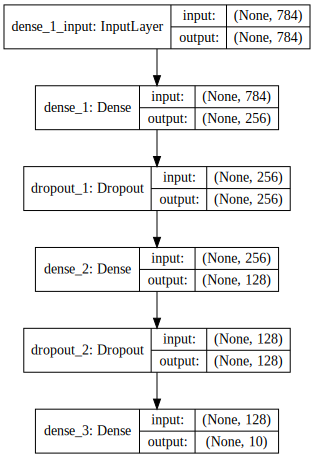

In [46]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg',))

# За визуализациите трябва да инсталирате и:
```
sudo pip install pydot-ng
brew install graphviz
```

# Dropout

![](imgs/dropout.jpeg)

# Functional model

Позволя създаването на други архитектури, вместо feed-forward мрежи.

In [47]:
from keras.layers import Input, Concatenate
from keras.models import Model

# This returns a tensor
inputs = Input(shape=(784,))

# a layer instance is callable on a tensor, and returns a tensor
x = Dense(64, activation='relu', name='L1_64_relu')(inputs)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu', name='L2_64_relu')(x)
x = Dropout(0.2)(x)

h = Dense(128, activation='elu', name="L1_128_elu")(inputs)
h = Dropout(0.5)(h)

x = Concatenate()([x, h])
predictions = Dense(10, activation='softmax', name='Softmax')(x)

# This creates the model
model = Model(inputs=inputs, outputs=predictions)

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [48]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
L1_64_relu (Dense)              (None, 64)           50240       input_1[0][0]                    
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 64)           0           L1_64_relu[0][0]                 
__________________________________________________________________________________________________
L2_64_relu (Dense)              (None, 64)           4160        dropout_3[0][0]                  
__________________________________________________________________________________________________
L1_128_elu

In [49]:
model.fit(x_train, y_train, batch_size=128, epochs=10);

Epoch 1/10
60000/60000 [==============================] - 3s 56us/step - loss: 0.3824 - acc: 0.8865
Epoch 2/10
60000/60000 [==============================] - 3s 47us/step - loss: 0.2077 - acc: 0.9379
Epoch 3/10
60000/60000 [==============================] - 3s 48us/step - loss: 0.1654 - acc: 0.9508
Epoch 4/10
60000/60000 [==============================] - 3s 47us/step - loss: 0.1431 - acc: 0.9564
Epoch 5/10
60000/60000 [==============================] - 3s 52us/step - loss: 0.1263 - acc: 0.9627
Epoch 6/10
60000/60000 [==============================] - 3s 46us/step - loss: 0.1168 - acc: 0.9651
Epoch 7/10
60000/60000 [==============================] - 3s 47us/step - loss: 0.1062 - acc: 0.9675
Epoch 8/10
60000/60000 [==============================] - 3s 46us/step - loss: 0.0990 - acc: 0.9697
Epoch 9/10
60000/60000 [==============================] - 3s 46us/step - loss: 0.0956 - acc: 0.9707
Epoch 10/10
60000/60000 [==============================] - 3s 47us/step - loss: 0.0892 - acc: 0.9735

In [50]:
score = model.evaluate(x_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 1s 53us/step
Test loss: 0.0884788031693
Test accuracy: 0.9761


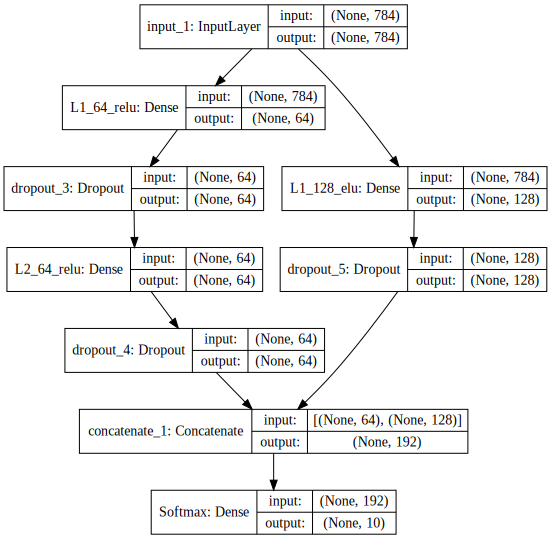

In [51]:
SVG(model_to_dot(model, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))

# Пример на мрежа с няколко различни входа и изхода.

![](imgs/multi-input-multi-output-graph.png)

# Записване и зареждане на модела на диска

In [52]:
# pip install h5py

model.save('model.hdf5')
!ls -lh model.hdf5

-rw-r--r--  1 lachezar  staff   1,2M 30 Нов 16:58 model.hdf5


In [53]:
new_model = keras.models.load_model('model.hdf5')

score = new_model.evaluate(x_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 1s 51us/step
Test loss: 0.0884788031693
Test accuracy: 0.9761


# Предсказване на категорийте

In [54]:
y_hat = new_model.predict(x_test[:4])
print(y_hat)
print(np.argmax(y_hat, axis=1))
print(np.argmax(y_test[:4], axis=1))

[[  1.57085789e-10   9.36015265e-10   1.70116937e-06   4.00841282e-06
    2.73315810e-12   3.66324144e-08   3.71637479e-16   9.99993563e-01
    1.91233229e-09   7.72712099e-07]
 [  6.41493914e-10   3.52659022e-08   9.99999642e-01   3.71865838e-07
    3.19827316e-18   1.03249319e-11   2.80265150e-13   1.65241844e-13
    7.14501652e-11   7.65649594e-19]
 [  3.02232017e-08   9.99088049e-01   2.40679743e-04   1.99665828e-06
    1.85227327e-05   7.18639399e-07   1.53430983e-06   6.14820048e-04
    3.27115522e-05   9.60526677e-07]
 [  9.99697924e-01   1.90893928e-07   6.13768061e-05   7.02689306e-07
    2.55131090e-06   4.09762542e-05   1.28325424e-04   1.92228290e-05
    9.54459665e-07   4.78333677e-05]]
[7 2 1 0]
[7 2 1 0]


# Да погледнем какви класове имаме на разположение в `keras.optimizers`

In [55]:
[c for c in dir(keras.optimizers) if c[0].isupper()]

['Adadelta',
 'Adagrad',
 'Adam',
 'Adamax',
 'K',
 'Nadam',
 'Optimizer',
 'RMSprop',
 'SGD',
 'TFOptimizer']

# И какви слоеве има в `keras.layers`

In [56]:
[c for c in dir(keras.layers) if c[0].isupper()]

['Activation',
 'ActivityRegularization',
 'Add',
 'AlphaDropout',
 'AtrousConv1D',
 'AtrousConv2D',
 'AtrousConvolution1D',
 'AtrousConvolution2D',
 'Average',
 'AveragePooling1D',
 'AveragePooling2D',
 'AveragePooling3D',
 'AvgPool1D',
 'AvgPool2D',
 'AvgPool3D',
 'BatchNormalization',
 'Bidirectional',
 'Concatenate',
 'Conv1D',
 'Conv2D',
 'Conv2DTranspose',
 'Conv3D',
 'Conv3DTranspose',
 'ConvLSTM2D',
 'ConvRecurrent2D',
 'Convolution1D',
 'Convolution2D',
 'Convolution2DTranspose',
 'Convolution3D',
 'Cropping1D',
 'Cropping2D',
 'Cropping3D',
 'CuDNNGRU',
 'CuDNNLSTM',
 'Deconv2D',
 'Deconv3D',
 'Deconvolution2D',
 'Deconvolution3D',
 'Dense',
 'Dot',
 'Dropout',
 'ELU',
 'Embedding',
 'Flatten',
 'GRU',
 'GRUCell',
 'GaussianDropout',
 'GaussianNoise',
 'GlobalAveragePooling1D',
 'GlobalAveragePooling2D',
 'GlobalAveragePooling3D',
 'GlobalAvgPool1D',
 'GlobalAvgPool2D',
 'GlobalAvgPool3D',
 'GlobalMaxPool1D',
 'GlobalMaxPool2D',
 'GlobalMaxPool3D',
 'GlobalMaxPooling1D',
 'Gl

# Следващият път:
    * Unsupervised NN:
    * Autoencoders
    * Word Embeddings

Ако има останало време, ще погледнем документацията на [керас](https://keras.io/).